In [4]:
library(dplyr)
library(reshape2)
library(tibble)
library(xtable)

## Plotting
library(ggplot2)
library(cowplot)
# library(RColorBrewer)

theme_set(theme_bw())


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [21]:
source("../../R/calc.R")
source("../../R/misc.R")
source("../../R/normalise.R")
source("../../R/plot.R")
source("../../R/predict.R")
source("../../R/subset.R")
source("../../R/utils.R")

## Import data

In [6]:
### ANNOTATIONS
METADATA_SID <- "../../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"

metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')
metadata_pid$label <- as.factor(metadata_pid$label)

### DATA
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


In [7]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

## Evaluation - Scoring table
Predictions at 3 different timepoints (incorporate MRD if information is available at time point)
1. D8 (Probability estimation without MRD)
2. D33 (" with D33 MRD)
3. Long-term (" with D33 and W12 MRD)

Evaluation:
1. According to final treatment arm
2. According to treatment at prediction timepoint (viz. D8, D33, TP2)

In [8]:
RPATH <- "../../data/evaluation/evaluation_table.txt"
scoring_table <- read.table(RPATH, header = T, sep = "\t")
rownames(scoring_table) <- paste0(
  scoring_table$treatment,
  scoring_table$label,
  scoring_table$prediction
)

In [9]:
p_d8 <- read.table("../../tmp/p_d8.tsv", sep = "\t")
p_d33 <- read.table("../../tmp/p_d33.tsv", sep = "\t")
p_tp2 <- read.table("../../tmp/p_tp2.tsv", sep = "\t")

### Evaluation: According to final treatment arm

In [14]:
#' Assign risk level and score based on probability predictions
#'
#' @param proba dataframe consisting of prediction probabilities
#' @param metadata dataframe of patient metadata
#' @param score_type character indicating column name to use for score
#' @param treatment_current character vector of current treatment to add to prediction dataframe
score_predictions <- function(
  proba, metadata,
  scoring_table, score_type,
  treatment_current = NULL
) {
  proba$treatment <- as.character(metadata[rownames(proba), "treatment"])
  proba$treatment[proba$treatment %in% c("HR1", "HR2", "BMT")] <- "HR"
  proba$label <- metadata[rownames(proba), "label"]
  proba$prediction <- "IR"
  proba$prediction[proba[1] > 0.5] <- "SR"
  proba$prediction[proba[1] <= 0.25] <- "HR"
  
  if (is.null(treatment_current)) {
    # Scoring predictions
    row_idx <- paste0(
      proba$treatment,
      proba$label,
      proba$prediction
    )
    proba$scores <- scoring_table[row_idx, score_type]
  } else{
    proba <- add_column(proba, treatment_current, .after = "treatment")
    # Scoring predictions
    row_idx <- paste0(
      proba$treatment_current,
      proba$label,
      proba$prediction
    )
    proba$scores <- scoring_table[row_idx, score_type]
  }
  
  # Change levels only after scoring
  levels(proba$label) <- c("Remission", "Relapse")
  
  proba
}

In [15]:
pred_d8 <- score_predictions(p_d8, metadata_pid, scoring_table, "score_3")
pred_d33 <- score_predictions(p_d33, metadata_pid, scoring_table, "score_3")
pred_tp2 <- score_predictions(p_tp2, metadata_pid, scoring_table, "score_3")

#### Theoretical scores if treatment levels were used as prediction

| Outcome | HR | IR | SR |
| --- | --- | --- | --- |
| Remission | 1 | 1 | 1 |
| Relapse | 1 | 0 | 0 |

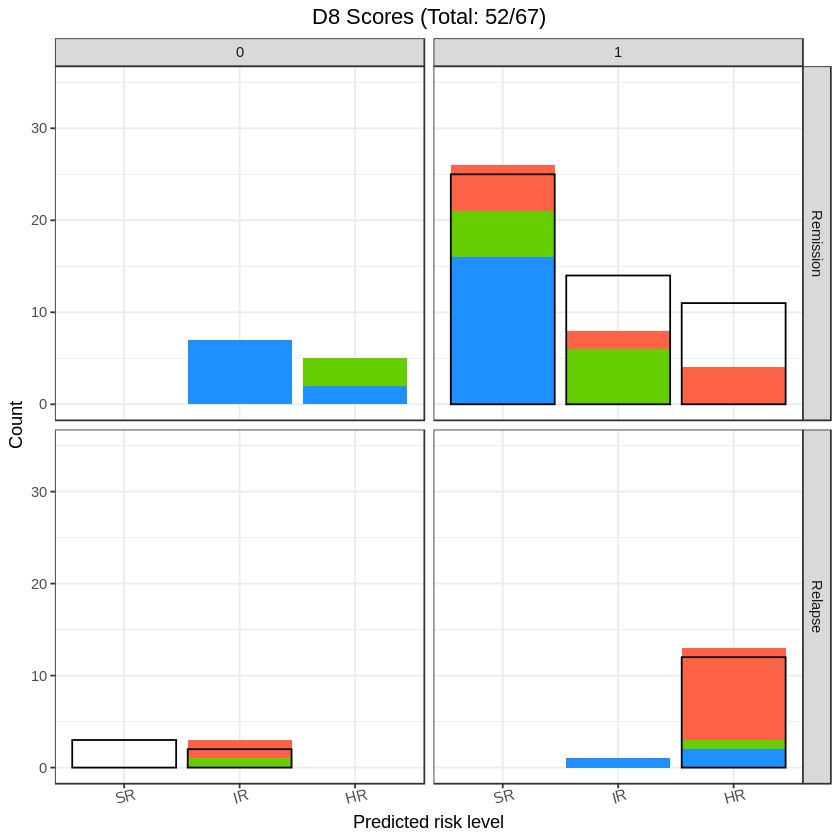

In [30]:
barchart_d8 <- plot_barchart(pred_d8, "D8", treatment = "treatment")
barchart_d8

file <- "~/Dropbox/tmp/barchart_final-d8.pdf" 
ggsave(file, barchart_d8, width = 3.5, height = 3.5)

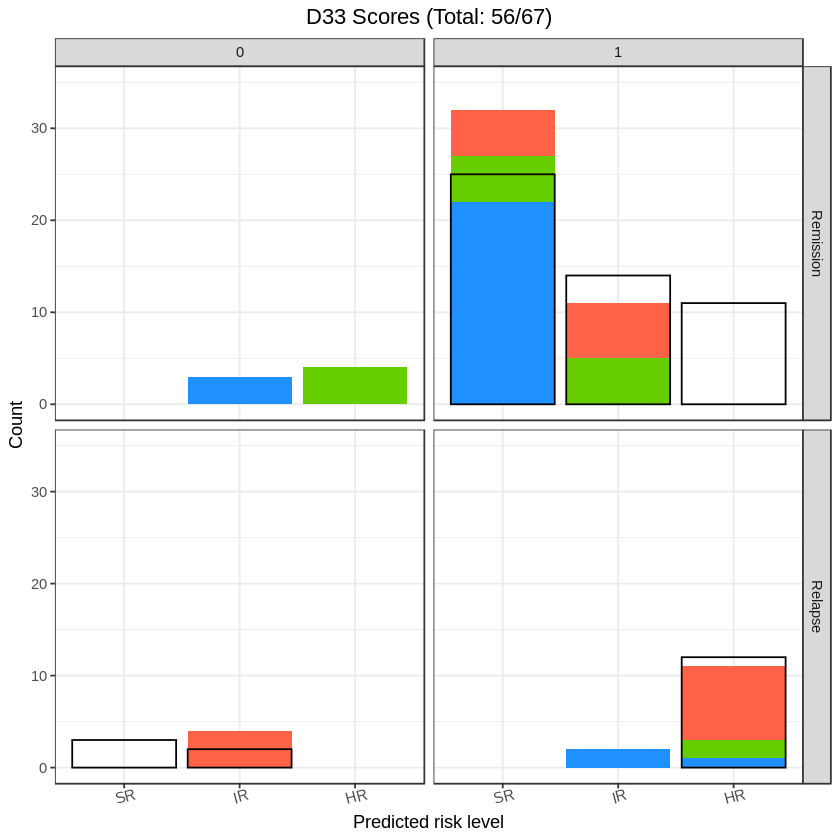

In [31]:
barchart_d33 <- plot_barchart(pred_d33, "D33", treatment = "treatment")
barchart_d33

file <- "~/Dropbox/tmp/barchart_final-d33.pdf" 
ggsave(file, barchart_d33, width = 3.5, height = 3.5)

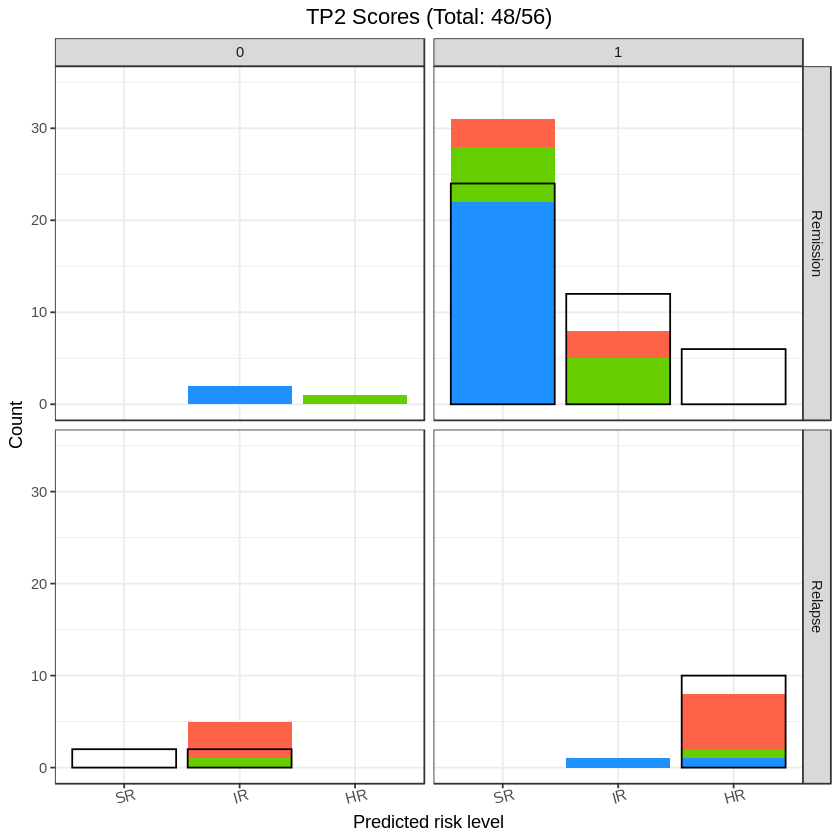

In [32]:
barchart_tp2 <- plot_barchart(pred_tp2, "TP2", treatment = "treatment")
barchart_tp2

file <- "~/Dropbox/tmp/barchart_final-tp2.pdf"
ggsave(file, barchart_tp2, width = 3.5, height = 3.5)

### Evaluation: According to treatment at prediction timepoint
1. D8 (Treatment: All IR)
2. D33 (Treatment: IR or HR1)

In [33]:
# Evaluation at D8 (All IR)
treatment_d8 <- rep("IR", nrow(p_d8))

pred_current_d8 <- score_predictions(
  p_d8, metadata_pid, scoring_table, "score_3", treatment_d8
)

In [34]:
# Evaluation at D33 (IR / HR1)
# INFO: P184 has NA treatment but undergoes BMT
# Remove patients with treatment_processed: NA
treatment_d33 <- as.character(
  metadata_pid[rownames(p_d33), "treatment_processed"]
)
is_na <- is.na(treatment_d33)
treatment_d33 <- treatment_d33[!is_na]

treatment_d33[treatment_d33 == "SR"] <- "IR"
treatment_d33[treatment_d33 == "HR2"] <- "IR"
treatment_d33[treatment_d33 == "HR1"] <- "HR"

pred_current_d33 <- score_predictions(
  p_d33[!is_na, , drop = F], metadata_pid, scoring_table, "score_3", treatment_d33
)

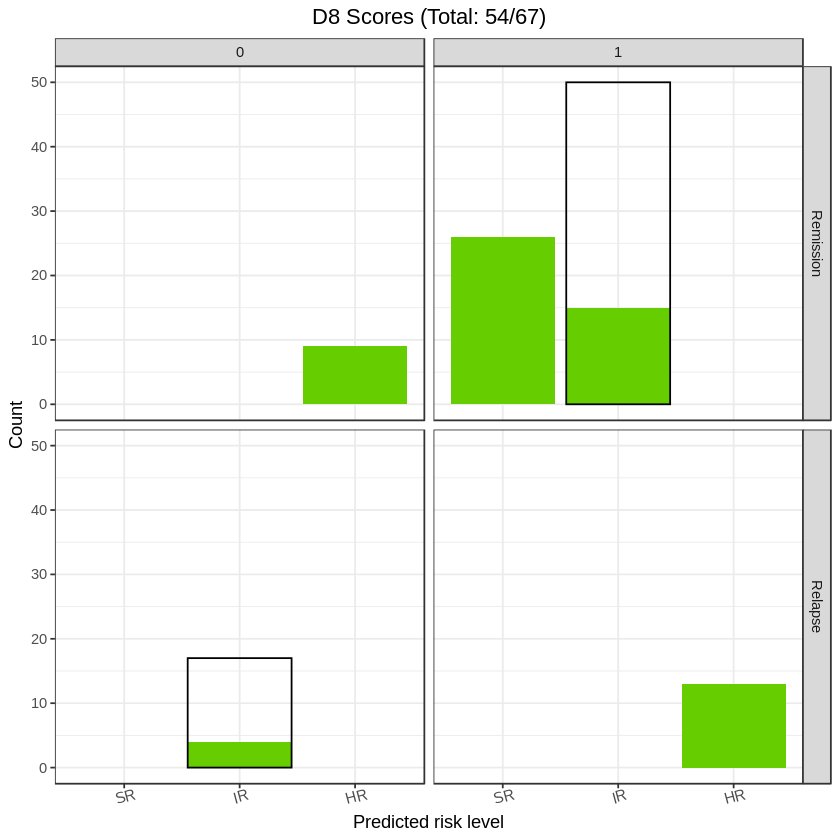

In [35]:
barchart_d8 <- plot_barchart(
  pred_current_d8, "D8", treatment = "treatment_current", ylim = c(0, 50)
)
barchart_d8

file <- "~/Dropbox/tmp/barchart_current-d8.pdf" 
ggsave(file, barchart_d8, width = 3.5, height = 3.5)

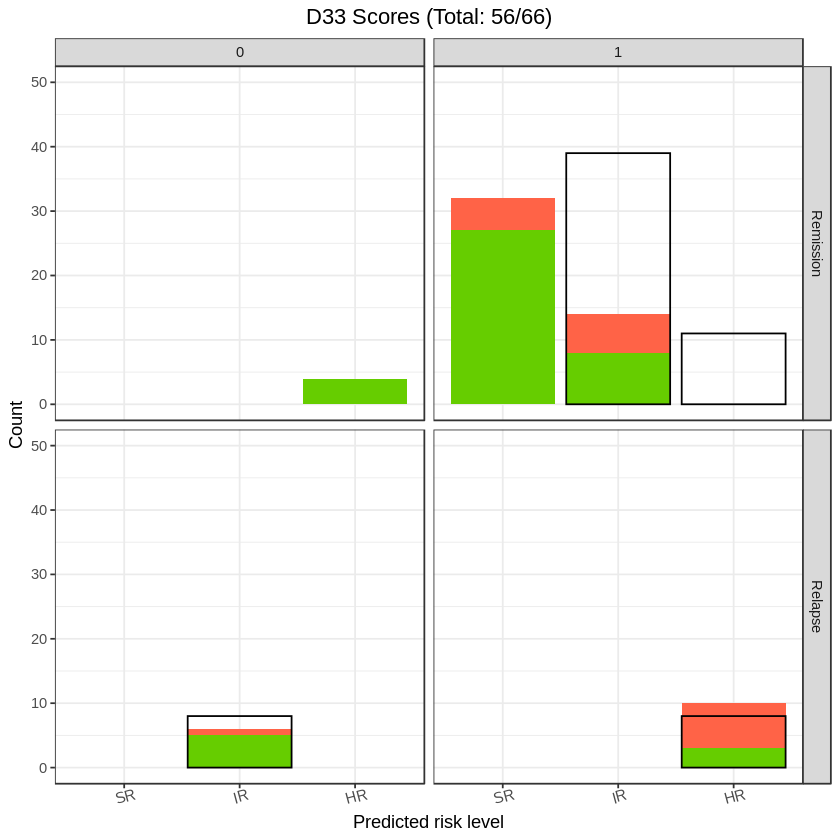

In [36]:
barchart_d33 <- plot_barchart(
  pred_current_d33, "D33", treatment = "treatment_current", ylim = c(0, 50)
)
barchart_d33

file <- "~/Dropbox/tmp/barchart_current-d33.pdf"
ggsave(file, barchart_d33, width = 3.5, height = 3.5)

### Investigation
- More concerned with relapse patients that have a score of 0
    - We recommend de-escalation in these patients which eventually relapse
- Less concerned with remission patients with a score of 0
- Prediction of SR/IR probably because of favourable ERM
- Not concerned with their final treatment and score

In [55]:
# Subsetting relapse patients predicted as IR/SR
pred_d8_sub <- pred_d8 %>%
  subset(label == "Relapse" & prediction %in% c("SR", "IR"))
print(pred_d8_sub)

pred_d33_sub <- pred_d33 %>%
  subset(label == "Relapse" & prediction %in% c("SR", "IR"))
print(pred_d33_sub)

pid_relapse_d8 <- rownames(pred_d8_sub)
writeLines(pid_relapse_d8, "../../tmp/pid_relapse_srir-d8.txt")

pid_relapse <- rownames(pred_d33_sub)
writeLines(pid_relapse, "../../tmp/pid_relapse_srir-d33.txt")

          p_d8 treatment   label prediction scores
P056 0.2666667        HR Relapse         IR      0
P151 0.4166667        HR Relapse         IR      0
P029 0.2528736        IR Relapse         IR      0
P136 0.2988506        SR Relapse         IR      1
         p_d33 treatment   label prediction scores
P056 0.3000000        HR Relapse         IR      0
P007 0.2812500        HR Relapse         IR      0
P151 0.3750000        HR Relapse         IR      0
P034 0.3017241        HR Relapse         IR      0
P094 0.2672414        SR Relapse         IR      1
P136 0.4741379        SR Relapse         IR      1


In [54]:
metadata_pid[rownames(pred_d8_sub), c("subtype", "treatment")]

,subtype,treatment
,<fct>,<fct>
P056,BCR-ABL,HR1
P151,T-ALL,HR2
P029,TEL-AML1,IR
P136,TEL-AML1,SR


In [ ]:
# metadata_sub <- subset(
#   metadata_pid,
#   treatment == "BMT",
#   c("subtype", "treatment_raw", "treatment_processed", "treatment")
# )
# print(metadata_sub)

In [ ]:
# x_d8 <- subset(p_d8, scores == 1)
# pid_1 <- rownames(x_d8)
# print(x_d8)
# metadata_pid1[pid_1, "treatment", drop = F]

In [ ]:
# x_d33 <- subset(p_d33, scores == 1)
# pid_1 <- rownames(x_d33)
# print(x_d33)
# metadata_pid1[pid_1, "treatment", drop = F]